# Statistical analysis in `nilearn`

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from nilearn import datasets

os.environ["NILEARN_SHARED_DATA"] = "~/shared/data/nilearn_data"
datasets.get_data_dirs()

['~/shared/data/nilearn_data', '/Users/emdupre/nilearn_data']

In the previous examples, we've generated connectivity matrices as our features-of-interest for machine learning.
However, there are many other kinds of relevant features we may want to extract from neuroimaging data.
Alternatively, we may not be interested in doing machine learning at all,
but instead performing statistical analysis using methods such as the General Linear Model (GLM).

In this example, we'll perform a GLM analysis of a dataset provided by the Haxby Lab,
in which participants were shown a number different categories of visual images.

In this example, we'll focus on within-participant analyses, taking advantage of the large number of stimuli each participant saw.
In reviewing this material, I'd encourage you to try to change the participant used in this example to see how the results change !

## Accessing and understanding the Haxby dataset

First, we need to download the dataset and its associated stimuli.

In [3]:
import numpy as np
import pandas as pd

from nilearn.datasets import fetch_haxby

haxby_dataset = fetch_haxby(subjects=(2,), fetch_stimuli=True)

# set TR in seconds, following information in the original paper
t_r = 2.5
print(haxby_dataset.description)

[fetch_haxby] Dataset found in /Users/emdupre/nilearn_data/haxby2001
.. _haxby_dataset:

Haxby dataset

Access
------
See :func:`nilearn.datasets.fetch_haxby`.

Notes
-----
Results from a classical :term:`fMRI` study that investigated the differences between
the neural correlates of face versus object processing in the ventral visual
stream. Face and object stimuli showed widely distributed and overlapping
response patterns.

See :footcite:t:`Haxby2001`.

Content
-------
The "simple" dataset includes:
    :'func': Nifti images with bold data
    :'session_target': Text file containing run data
    :'mask': Nifti images with employed mask
    :'session': Text file with condition labels

The full dataset additionally includes
    :'anat': Nifti images with anatomical image
    :'func': Nifti images with bold data
    :'mask_vt': Nifti images with mask for ventral visual/temporal cortex
    :'mask_face': Nifti images with face-reponsive brain regions
    :'mask_house': Nifti images with h

Much as for the `development_dataset`, this `haxby_dataset` has several attributes that will be of interest for our analyses.
For example, `haxby_dataset.mask` provides access to the brain mask used in the original experiments.
We can use `haxby_dataset.func` to access the functional MRI (fMRI) data, one nii file for each participant.

There are 1452 TRs in the file /Users/emdupre/nilearn_data/haxby2001/subj2/bold.nii.gz


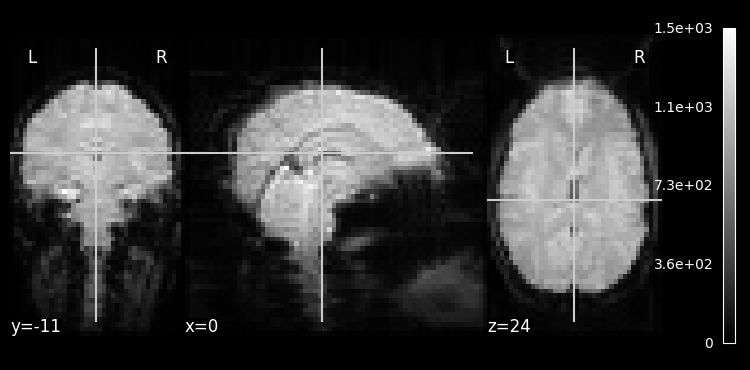

In [4]:
import nibabel as nib
from nilearn import image, plotting

mean_img_ = image.mean_img(haxby_dataset.func[0], copy_header=True)
plotting.plot_epi(mean_img_)

n_trs = nib.load(haxby_dataset.func[0]).shape[-1]
print(f"There are {n_trs} TRs in the file {haxby_dataset.func[0]}")

Unlike the `development_dataset`, the `haxby_dataset` also two additional attributes that are relevant for fitting our GLM.
First, `haxby_dataset.stimuli` allows us to access the original stimuli included in the experiment.
We will view a single image for each of the eight presented visual categories, to get an intuition for the experiment.

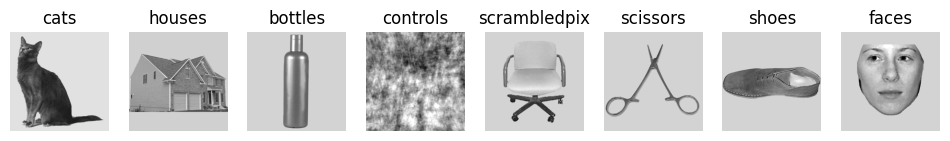

In [5]:
import matplotlib.pyplot as plt

key_stimuli = []
exp_stimuli = []
for key, values in haxby_dataset.stimuli.items():
    key_stimuli.append(key)

    try:
        exp_stimuli.append(values[0])
    except KeyError:
        exp_stimuli.append(values['scrambled_faces'][0])

# update naming convention of 'controls' to match labels in behavioral csv
key_stimuli[4] = 'scrambledpix' 

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 12))
# fig.suptitle("Example stimuli used in the experiment")

for img_path, img_categ, ax in zip(exp_stimuli, key_stimuli, axes.ravel()):
    ax.imshow(plt.imread(img_path), cmap="gray")
    ax.set_title(img_categ)

for ax in axes.ravel():
    ax.axis("off")

The second attribute that `haxby_dataset` has that will be of special interest to our GLM analyses is `haxby_dataset.session_target`.
This provides the path to a CSV file, one per each participant.
Let's load and view one CSV file to get a sense of its structure.

In [6]:
# Load target information as string 
events = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
events

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0
...,...,...
1447,rest,11
1448,rest,11
1449,rest,11
1450,rest,11


You may notice that the two columns in the CSV are `labels` and `chunks`.
As all runs have been concatenated into a single nii file, the run identifier is indicated in the `chunk` label.
Each entry in the CSV corresponds to the presentation of a single image, whose visual category is given by the `label` identifier.
Note that this means that each image was presented for a full TR, without any jitter in the presentation.

We can identify the unique runs and visual categories in this `session_target` CSV and compare them against our known stimuli.

In [7]:
unique_conditions = events["labels"].unique()
conditions = events["labels"].values
print(unique_conditions)

['rest' 'scissors' 'face' 'cat' 'shoe' 'house' 'scrambledpix' 'bottle'
 'chair']


In [8]:
# Record these as an array of runs
runs = events["chunks"].to_numpy()
unique_runs = events["chunks"].unique()
print(unique_runs)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


## Generate design matrices for each run

Now that we understand the structure of our dataset, we will use this information to generate "design matrices" for each run to use in our GLM.
For each run, let's quickly create a `pandas.DataFrame` with minimal timing information, including only the frame times, the trial type (i.e., the visual category), and the duration.
We'll gather all of these dataframes into a dictionary, with run indices as the keys.

In [9]:
# events will take the form of a dictionary of Dataframes, one per run
events = {}

for run in unique_runs:

    # get the condition label per run
    conditions_run = conditions[runs == run]

    # get the number of scans per run, then the corresponding
    # vector of frame times
    n_scans = len(conditions_run)
    frame_times = t_r * np.arange(n_scans)

    # each event lasts the full TR
    duration = t_r * np.ones(n_scans)

    # Define the events object
    events_ = pd.DataFrame(
        {
            "onset": frame_times,
            "trial_type": conditions_run,
            "duration": duration,
        }
    )
    # remove the rest condition and insert into the dictionary
    # this will be our baseline in the GLM, so we don't want to model it as a condition
    events[run] = events_[events_.trial_type != "rest"]

Now we can view one of these minimal timing information, just to see its structure:

In [10]:
events[0]

,onset,trial_type,duration
6,15.0,scissors,2.5
7,17.5,scissors,2.5
8,20.0,scissors,2.5
9,22.5,scissors,2.5
10,25.0,scissors,2.5
...,...,...,...
110,275.0,chair,2.5
111,277.5,chair,2.5
112,280.0,chair,2.5
113,282.5,chair,2.5


Nilearn also provides some nice functionality to convert this into a design matrix and view it in a more familar format:

<Axes: label='conditions', ylabel='scan number'>

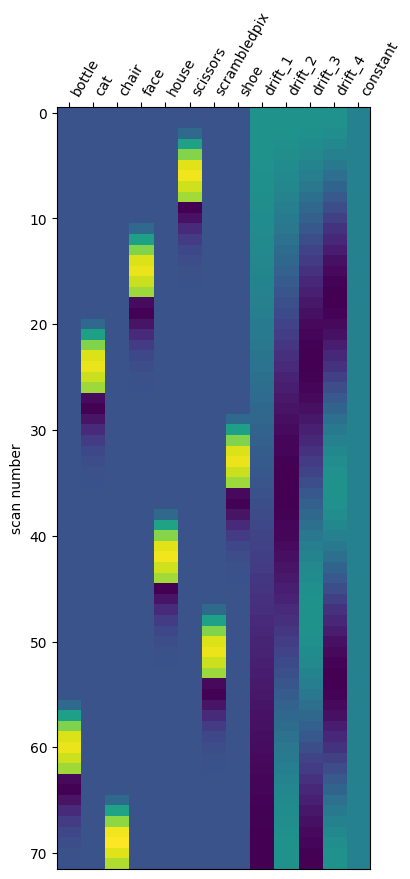

In [11]:
from nilearn.glm.first_level import make_first_level_design_matrix

X1 = make_first_level_design_matrix(
    events[0].onset.values,
    events[0],
    drift_model="cosine",
    high_pass=0.008,
    hrf_model="glover",
)
plotting.plot_design_matrix(X1)

One thing to note: You may remember from our previous example with `development_dataset` that it's really important to include confound information such as head motion.
Unfortunately, this dataset is older (published in 2001!) and so its head motion information is no longer available.
In real data, you want to make sure to include confound information when you create your design matrices.

## Run First-Level General Linear Models (GLMs)

We are now ready to run our General Linear Models using Nilearn !
Since we are working with within-participant data, these will be "first-level" models, which reflect only within-participant information.
Nilearn makes this very easy for us.
In particular, we can instantiate the `FirstLevelModel` estimator:

In [12]:
from nilearn.glm.first_level import FirstLevelModel

z_maps = []
conditions_label = []
run_label = []

# Instantiate the glm
glm = FirstLevelModel(
    t_r=t_r,
    mask_img=haxby_dataset.mask,
    high_pass=0.008,
    smoothing_fwhm=4,
)

Then our analysis is as simple as passing our functional image and our minimal timing information!
To learn about the processing of each visual category, we will also use the `compute_contrast` method.

In [13]:
from nilearn.image import index_img

for run in unique_runs:
    # grab the fmri data for that particular run
    fmri_run = index_img(haxby_dataset.func[0], runs == run)

    # fit the GLM
    glm.fit(fmri_run, events=events[run])

    # set up contrasts: one per condition
    conditions = events[run].trial_type.unique()
    for condition_ in conditions:
        z_maps.append(glm.compute_contrast(condition_))
        conditions_label.append(condition_)
        run_label.append(run)

Finally, we can check the generated report structure to learn about the GLM, including its design matrices and computed contrasts.


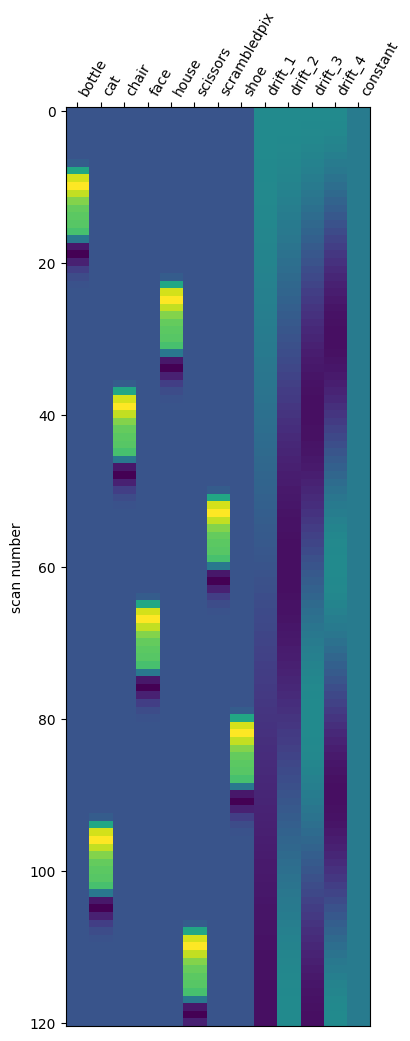
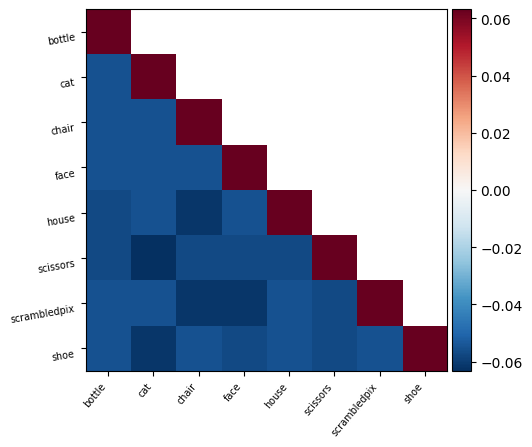
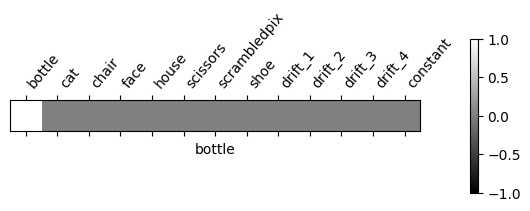
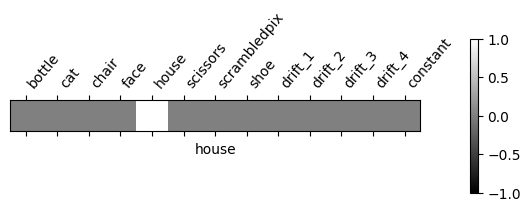
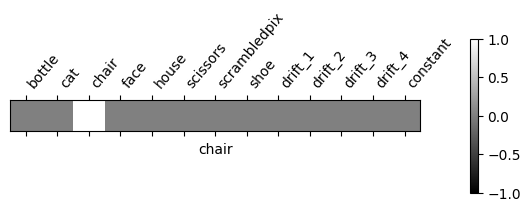
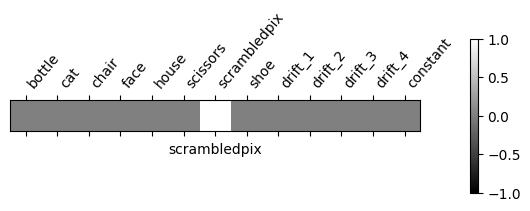
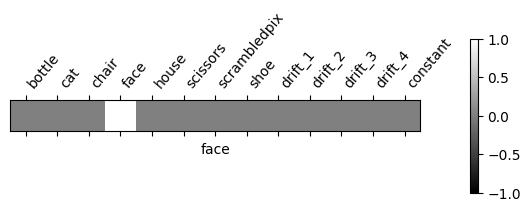
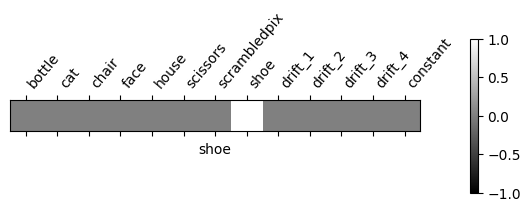
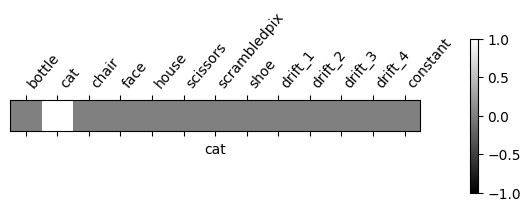
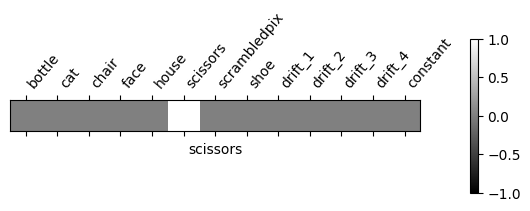
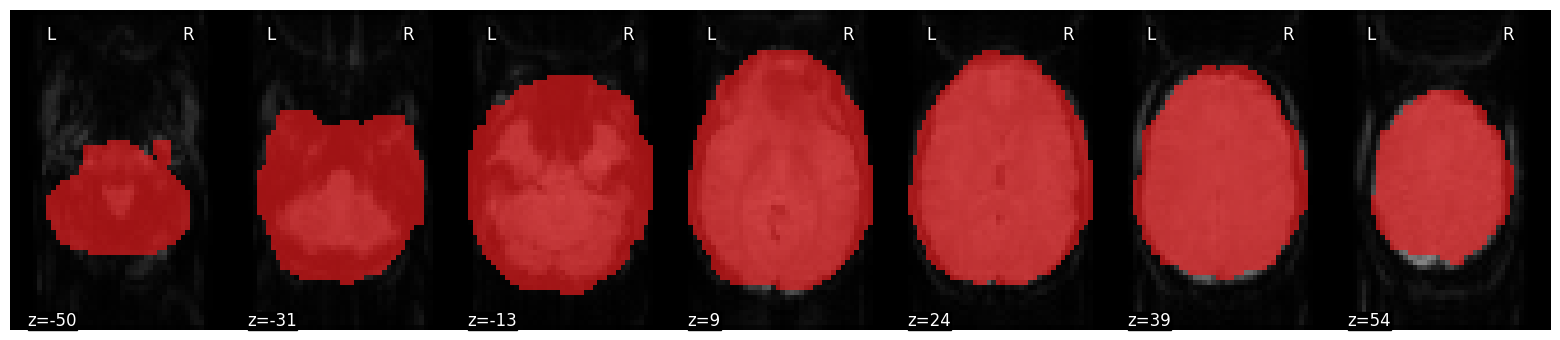
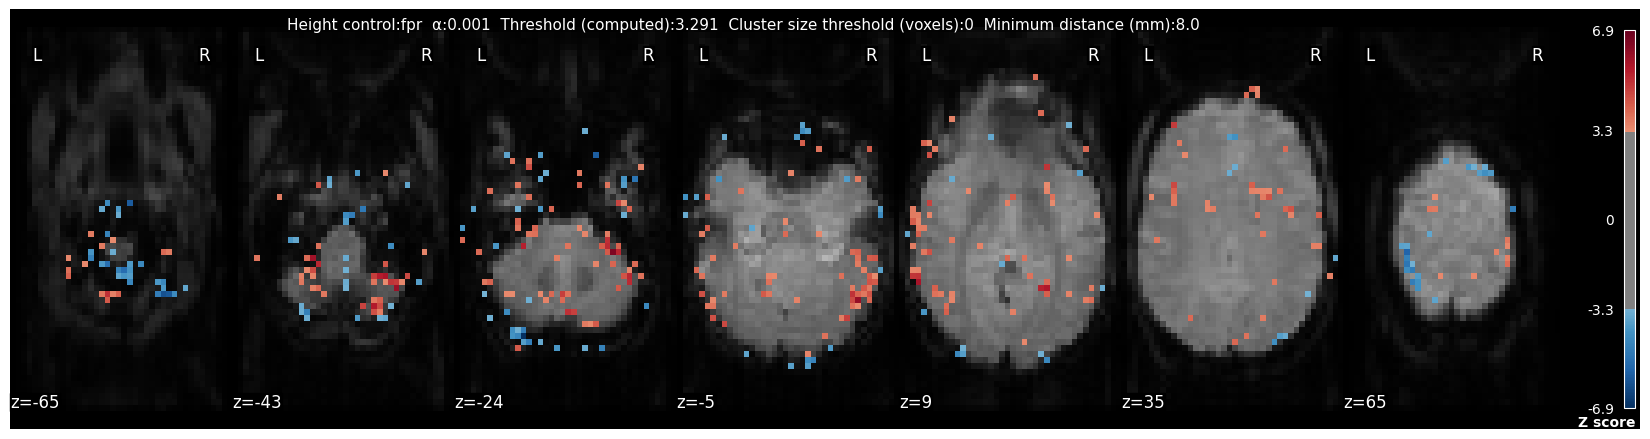
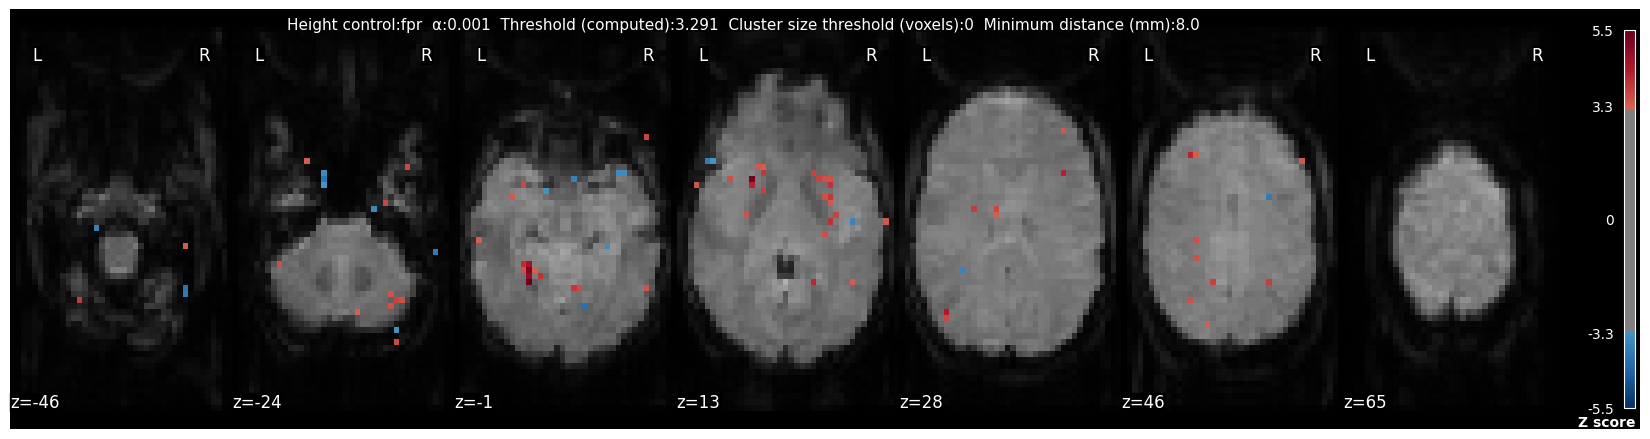
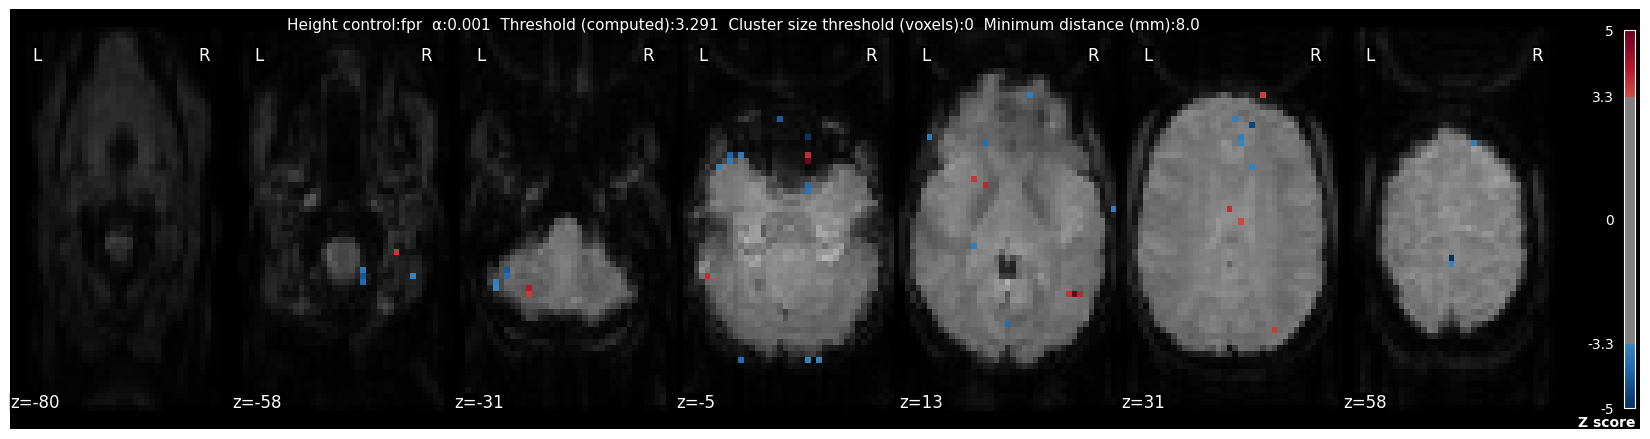
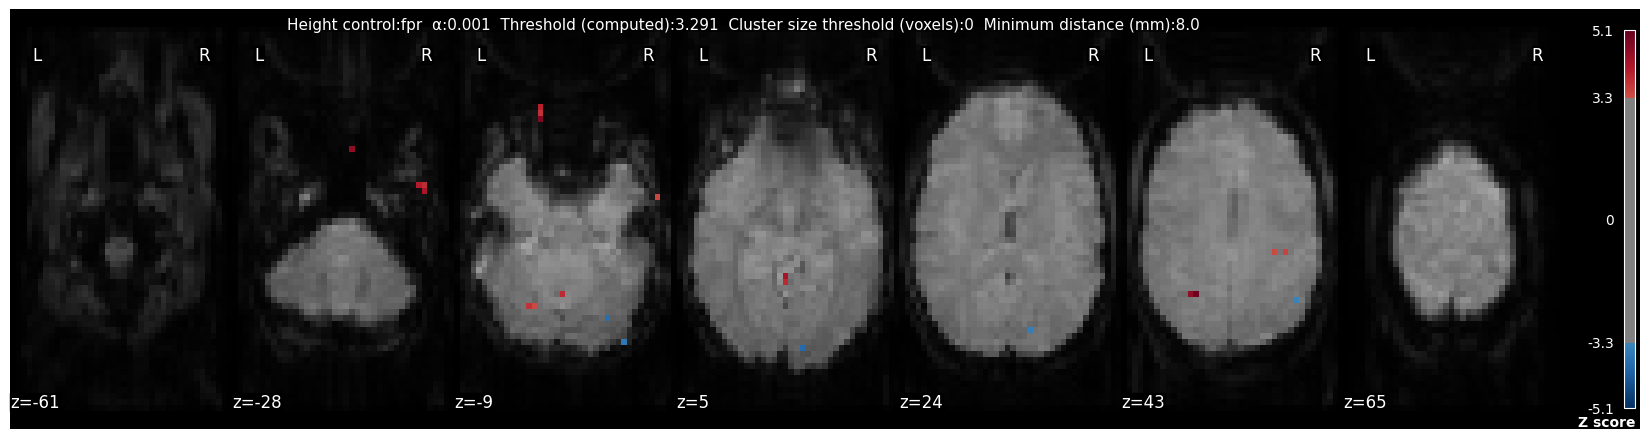
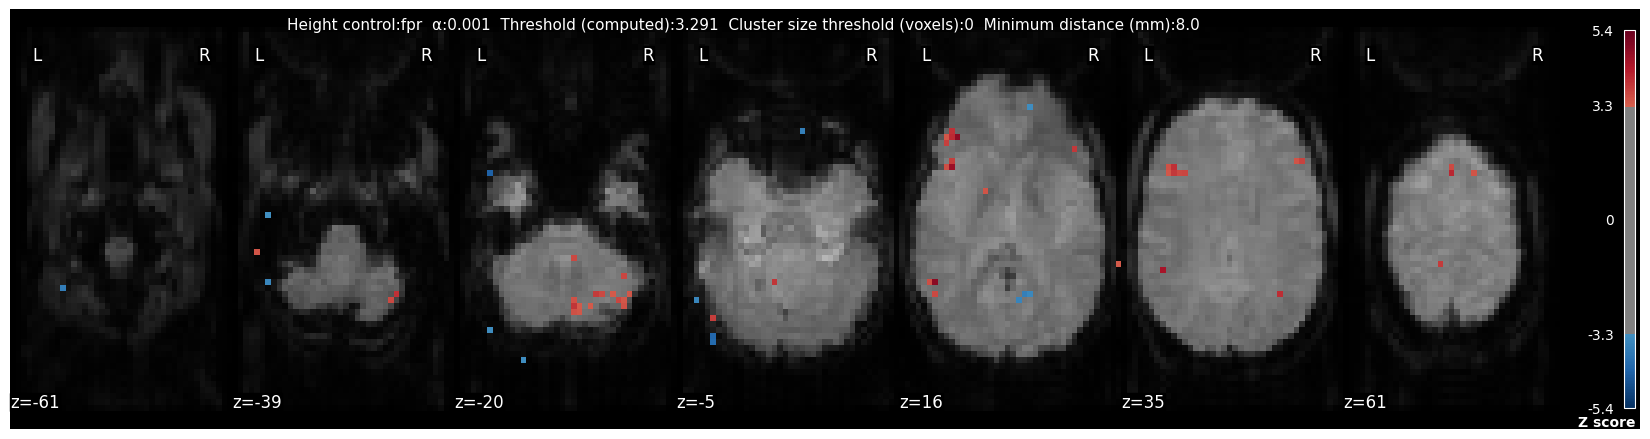
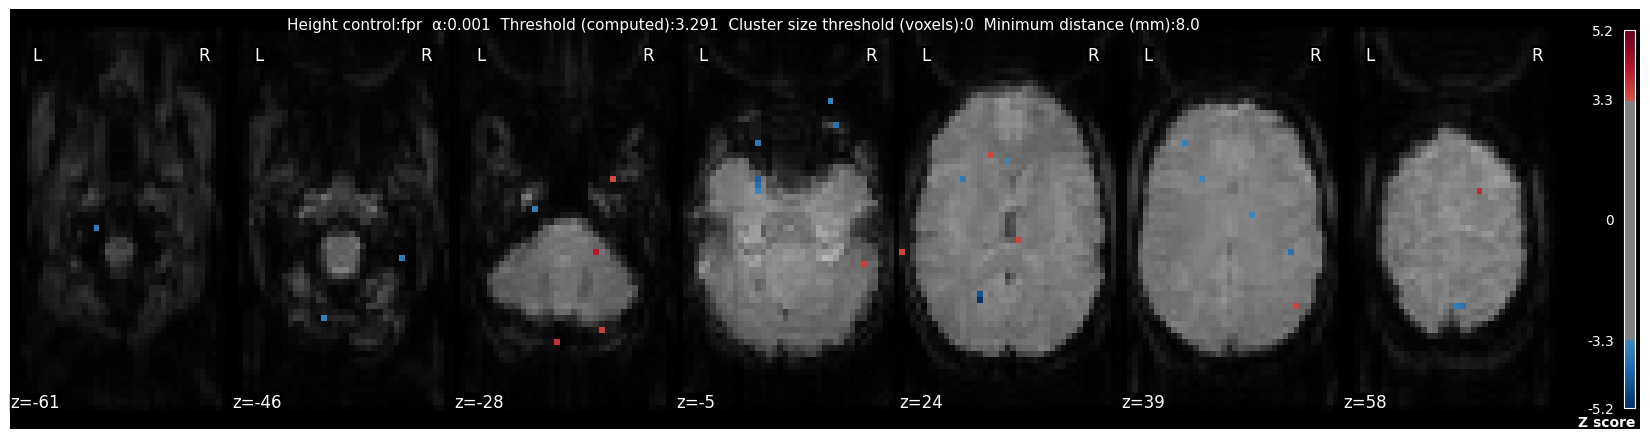
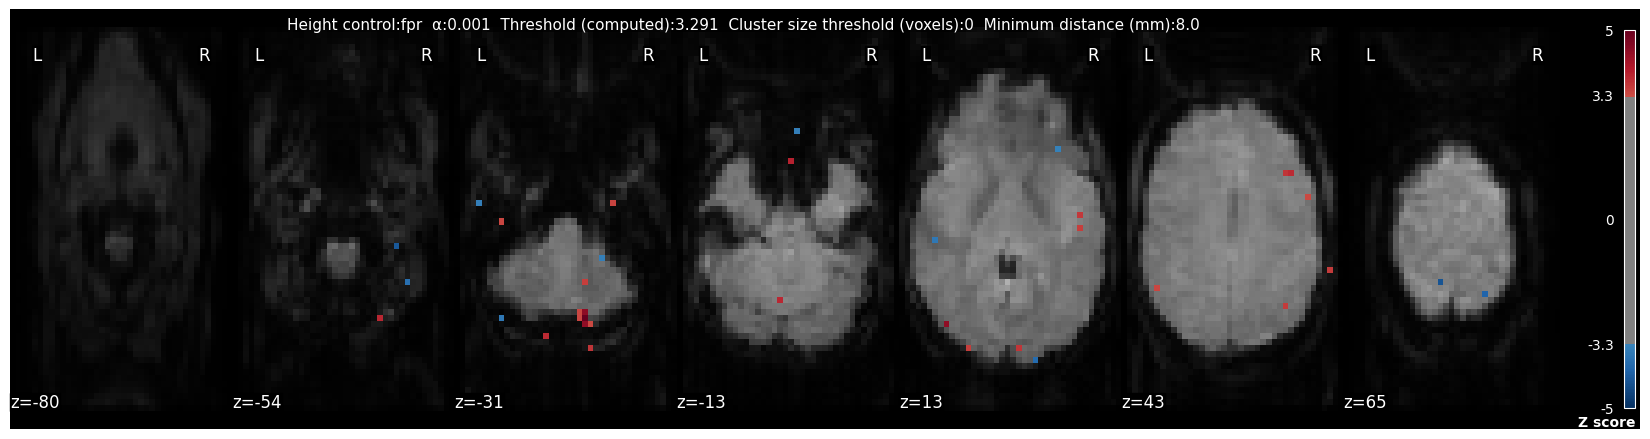
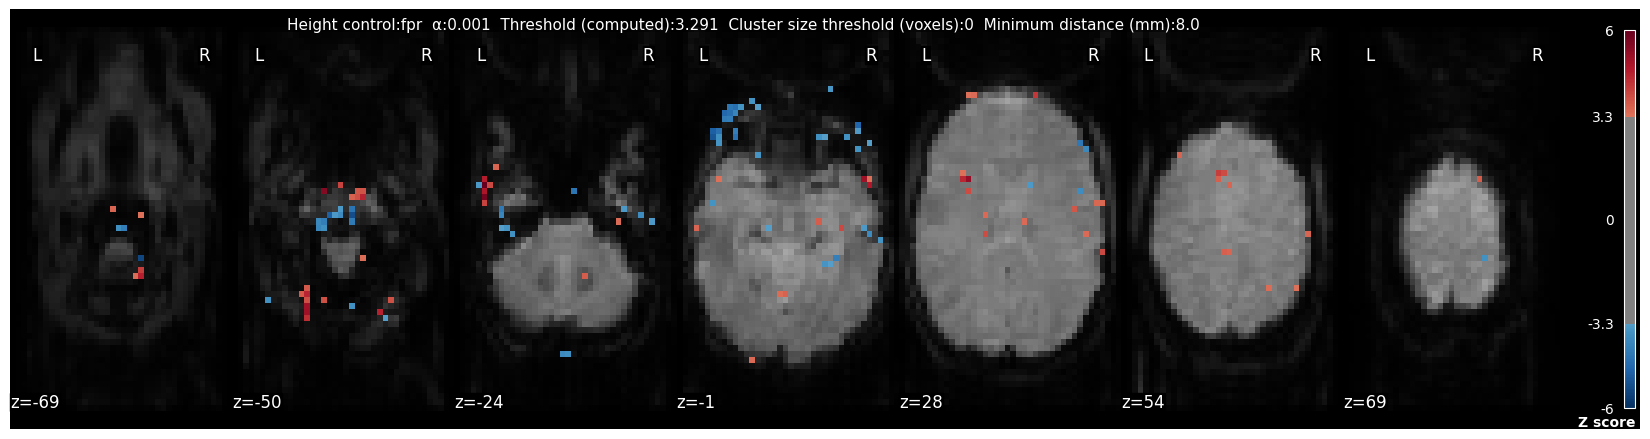

In [14]:
report = glm.generate_report(
    contrasts=conditions,
    bg_img=mean_img_,
)
report